# Machine Learning on Big Data

Overview of my Project:

In this project, I will  build a simple but powerful pipeline by taking public  kaggle dataset for  movie dataset (budget, revenue, genre, release date, popularity, votes, etc.) and predicts whether a film will be a “hit” or a “flop.” First, I will  clean and merge metadata, credits, and keywords, cast all the numeric fields correctly, engineer features like budget to revenue ratio and one hot encoded genre vectors, and label any movie that earns at least 25% profit a hit. Then I will train two different classifiers Logistic Regression, to understand  a straightforward boundary between hits and flops, and a Random Forest, to see more complex interactions among features. Finally, I will compare their performance using accuracy, precision, recall, F1 score, ROC curves, and confusion matrices to see which method best forecasts box office success.


# **Initiate and Configure Spark**

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, month, dayofmonth, mean,when, explode, split
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer,OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import random

# Initiate SparkSession
spark = SparkSession.builder \
                    .appName("Movie's hit or flop using Logistics Regression   and Random forest") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

spark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
# **Data Loading and Preprocessing**
---

In [ ]:
# Define CSV read options
csv_options = {
    "header": "true",
    "multiLine": "true",
    "quote": '"',
    "escape": '"',
    "mode": "DROPMALFORMED"
}



movies_path =  "/content/drive/MyDrive/My_project/Big_Data_Project/movies_metadata.csv"
credits_path ="/content/drive/MyDrive/My_project/Big_Data_Project/credits.csv"
keywords_path ="/content/drive/MyDrive/My_project/Big_Data_Project/keywords.csv"
links_path = "/content/drive/MyDrive/My_project/Big_Data_Project/links.csv"

# Load data into DataFrames using PySpark
movies_df = spark.read.options(**csv_options).csv(movies_path)
credits_df = spark.read.options(**csv_options).csv(credits_path)
keywords_df = spark.read.options(**csv_options).csv(keywords_path)
links_df = spark.read.options(**csv_options).csv(links_path)


# Convert necessary columns to integer for proper joins
movies_df = movies_df.withColumn("id", col("id").cast("int"))
links_df = links_df.withColumn("movieId", col("movieId").cast("int"))
links_df = links_df.withColumn("tmdbId", col("tmdbId").cast("int"))
credits_df = credits_df.withColumn("id", col("id").cast("int"))
keywords_df = keywords_df.withColumn("id", col("id").cast("int"))


# Join Links with Credits and Keywords using tmdbId
credits_joined = links_df.join(credits_df, links_df.tmdbId == credits_df.id, "inner").drop("id")
keywords_joined = links_df.join(keywords_df, links_df.tmdbId == keywords_df.id, "inner").drop("id")

# Join with Movies Metadata using 'id'
df = movies_df.join(credits_joined, movies_df.id == credits_joined.tmdbId, "left").drop("tmdbId")
df = df.join(keywords_joined, df.id == keywords_joined.tmdbId, "left").drop("tmdbId")

# Delete unnwanted  DataFrames
del movies_df, credits_df, keywords_df, links_df, credits_joined, keywords_joined

# dropping rows
df = df.withColumn("revenue", col("revenue").cast("int"))
df = df.withColumn("budget", col("budget").cast("int"))

df = df.filter(col("revenue") > 0)
df = df.filter(col("budget") > 0)


df.show()
df.printSchema()

#more information on data
print(df.count())
print(df.rdd.getNumPartitions())

+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+-------+-------+--------------------+--------------------+-------+-------+--------------------+
|adult|belongs_to_collection|  budget|              genres|            homepage|   id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|  revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|movieId| imdbId|                cast|                crew|movieId| imdbId|            keywords|
+-----+---------------------+--------+--------------------+--------------------+--

In [ ]:
from pyspark.sql.functions import col, mean, when

# Drop unnecessary columns
columns_to_drop = ['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'production_companies',
                   'overview', 'production_countries', 'status', 'tagline', 'video', 'adult', 'spoken_languages']
df = df.drop(*columns_to_drop)

# Check for duplicate columns and drop extra 'movieId' if it exists
if df.columns.count('movieId') > 1:
    df = df.drop("movieId")


# Check if 'movieId' column exists before attempting to fill its missing values
if 'movieId' in df.columns:
    df = df.fillna({'movieId': -1})

# Converting numerical columns to double type
numeric_columns = ['budget', 'id', 'popularity', 'revenue', 'runtime', 'vote_average','cast','crew']
for col_name in numeric_columns:
    df = df.withColumn(col_name, col(col_name).cast('double'))

# Drop rows with crucial missing values
df = df.na.drop(subset=['release_date', 'runtime', 'revenue', 'budget', 'popularity', 'vote_count'])

# Fill missing categorical values with 'Not Specified'
df = df.fillna({'original_language': 'Not Specified', 'title': 'Not Specified',
                'original_title': 'Not Specified', 'cast': 'Not Specified', 'crew': 'Not Specified','keywords':'Not Specified'})

# Fill missing numerical values with the mean
for col_name in ['runtime', 'revenue', 'popularity', 'vote_average']:
    mean_value = df.select(mean(col(col_name))).collect()[0][0]
    df = df.withColumn(col_name, when(col(col_name).isNull(), mean_value).otherwise(col(col_name)))

# Replace missing values in budget and revenue with the mean
mean_budget = df.select(mean(col('budget'))).collect()[0][0]
df = df.withColumn('budget', when((col('budget') == 0) | col('budget').isNull(), mean_budget).otherwise(col('budget')))

# Show dataset
df.show(10)




+---------+--------------------+----+-----------------+--------------------+----------+------------+------------+-------+--------------------+------------+----------+-------+----+----+-------+--------------------+
|   budget|              genres|  id|original_language|      original_title|popularity|release_date|     revenue|runtime|               title|vote_average|vote_count| imdbId|cast|crew| imdbId|            keywords|
+---------+--------------------+----+-----------------+--------------------+----------+------------+------------+-------+--------------------+------------+----------+-------+----+----+-------+--------------------+
|4000000.0|[{'id': 80, 'name...| 5.0|               en|          Four Rooms|  9.026586|  1995-12-09|   4300000.0|   98.0|          Four Rooms|         6.5|       539|0113101|NULL|NULL|0113101|[{'id': 612, 'nam...|
|    9.4E7|[{'id': 16, 'name...|12.0|               en|        Finding Nemo| 25.497794|  2003-05-30|9.40335536E8|  100.0|        Finding Nemo|  

In [ ]:
#Convert release_date into date-time format and extract year, month and day

df = df.withColumn('release_date', to_date(col('release_date'), 'yyyy-MM-dd'))
df = df.withColumn('release_year', year(col('release_date')))
df = df.withColumn('release_month', month(col('release_date')))
df = df.withColumn('release_day', dayofmonth(col('release_date')))
df = df.drop('release_date')

df.show()

+---------+--------------------+-----+-----------------+--------------------+----------+------------+-------+--------------------+------------+----------+-------+----+----+-------+--------------------+------------+-------------+-----------+
|   budget|              genres|   id|original_language|      original_title|popularity|     revenue|runtime|               title|vote_average|vote_count| imdbId|cast|crew| imdbId|            keywords|release_year|release_month|release_day|
+---------+--------------------+-----+-----------------+--------------------+----------+------------+-------+--------------------+------------+----------+-------+----+----+-------+--------------------+------------+-------------+-----------+
|4000000.0|[{'id': 80, 'name...|  5.0|               en|          Four Rooms|  9.026586|   4300000.0|   98.0|          Four Rooms|         6.5|       539|0113101|NULL|NULL|0113101|[{'id': 612, 'nam...|        1995|           12|          9|
|    9.4E7|[{'id': 16, 'name...| 12.

In [ ]:
from pyspark.sql.functions import col, split
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Extract the first genre
df = df.withColumn("genres", split(col("genres"), ",").getItem(0))

# Drop genre_index if it exists already
if 'genre_index' in df.columns:
    df = df.drop('genre_index')

# String index the genre column
indexer = StringIndexer(inputCol="genres", outputCol="genre_index")
df = indexer.fit(df).transform(df)

# Drop genre_vector if it exists already
if 'genre_vector' in df.columns:
    df = df.drop('genre_vector')

# One-hot encode the indexed genre
encoder = OneHotEncoder(inputCol="genre_index", outputCol="genre_vector")
df = encoder.fit(df).transform(df)

# Ensure all numerical feature columns are actually numbers (cast to double)
numeric_columns = ['budget', 'vote_count', 'popularity', 'revenue', 'runtime', 'vote_average', 'release_month', 'release_year']
for col_name in numeric_columns:
    df = df.withColumn(col_name, col(col_name).cast('double'))

# Features Enginearing
feature_columns = ['budget', 'vote_count', 'popularity', 'runtime', 'vote_average', 'genre_vector', 'release_month', 'revenue']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

# Clean up — remove columns  don’t need anymore
df = df.drop("genres", "genre_index")

# Show processed data
df.show(10, True)
df.printSchema()




+---------+----+-----------------+--------------------+----------+------------+-------+--------------------+------------+----------+-------+----+----+-------+--------------------+------------+-------------+-----------+---------------+--------------------+
|   budget|  id|original_language|      original_title|popularity|     revenue|runtime|               title|vote_average|vote_count| imdbId|cast|crew| imdbId|            keywords|release_year|release_month|release_day|   genre_vector|            features|
+---------+----+-----------------+--------------------+----------+------------+-------+--------------------+------------+----------+-------+----+----+-------+--------------------+------------+-------------+-----------+---------------+--------------------+
|4000000.0| 5.0|               en|          Four Rooms|  9.026586|   4300000.0|   98.0|          Four Rooms|         6.5|     539.0|0113101|NULL|NULL|0113101|[{'id': 612, 'nam...|      1995.0|         12.0|          9| (20,[5],[1.0]

In [ ]:
#Create a binary label to indicate when a movie is a hit or miss
# If movie made at least 25% profit, count it as a hit
df = df.withColumn('hit', when((col('revenue') - col('budget')) / col('budget') > 0.25, 1).otherwise(0))




In [ ]:
#StringIndexer
indexer = StringIndexer(inputCol = 'original_language',outputCol= 'indexed_language')
df = indexer.fit(df).transform(df)
df.show(10)

+---------+----+-----------------+--------------------+----------+------------+-------+--------------------+------------+----------+-------+----+----+-------+--------------------+------------+-------------+-----------+---------------+--------------------+---+----------------+
|   budget|  id|original_language|      original_title|popularity|     revenue|runtime|               title|vote_average|vote_count| imdbId|cast|crew| imdbId|            keywords|release_year|release_month|release_day|   genre_vector|            features|hit|indexed_language|
+---------+----+-----------------+--------------------+----------+------------+-------+--------------------+------------+----------+-------+----+----+-------+--------------------+------------+-------------+-----------+---------------+--------------------+---+----------------+
|4000000.0| 5.0|               en|          Four Rooms|  9.026586|   4300000.0|   98.0|          Four Rooms|         6.5|     539.0|0113101|NULL|NULL|0113101|[{'id': 612

In [ ]:
#Standard Scaler
scaler = StandardScaler(inputCol= 'features', outputCol= 'scaledFeatures')

df= scaler.fit(df).transform(df)
df = df.select('scaledFeatures','hit')
df.show(10, truncate= False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|scaledFeatures                                                                                                                                                                      |hit|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|(27,[0,1,2,3,4,6,25,26],[1.0116637459843678,0.06774687942595824,0.3722295954012088,5.858931518763183,6.423454031290991,2.5150621674646203,1.7524414818609642,0.15205609847466464])  |0  |
|(27,[0,1,2,3,4,8,25,26],[0.6456943858745228,0.06937933435188494,0.3402605975340157,4.348425736582049,5.770221417939363,3.481554465038878,1.4603679015508033,0.12548285558310154])   |0  |
|(27,[0,1,2,3,4,10,25,26],[1.0116637459843678,0.42607073566686987

In [ ]:
df.count()

5600

---
# **Model Selection and Implementation**
---


In [ ]:
#Rename scaledFeatures to features
df = df.withColumnRenamed("scaledFeatures", "features")

# split into train and test sets
train_data, test_data = df.select("features", "hit").randomSplit([0.8, 0.2], seed=42)

# Training my choosen  model
from pyspark.ml.classification import LogisticRegression
logistics_reg_declaration = LogisticRegression(labelCol="hit", featuresCol="features", maxIter=20)
logistics_model = logistics_reg_declaration.fit(train_data)


In [ ]:
# Make predictions on the test data
predictions = logistics_model.transform(test_data)
predictions.select("hit", "prediction").show(10, truncate=False)

+---+----------+
|hit|prediction|
+---+----------+
|1  |0.0       |
|1  |0.0       |
|1  |1.0       |
|1  |1.0       |
|1  |1.0       |
|1  |1.0       |
|1  |1.0       |
|1  |1.0       |
|0  |0.0       |
|0  |1.0       |
+---+----------+
only showing top 10 rows



In [ ]:
#Logistics Evaluator
confusion_matrix = predictions.groupBy("hit", "prediction").count()
confusion_matrix.show()

+---+----------+-----+
|hit|prediction|count|
+---+----------+-----+
|  1|       0.0|    9|
|  0|       0.0|  373|
|  1|       1.0|  671|
|  0|       1.0|   23|
+---+----------+-----+



In [ ]:

cm_pandas = confusion_matrix.toPandas()
cm_pandas.pivot(index ='hit',  columns = 'prediction', values = 'count')


prediction,0.0,1.0
hit,,
0,373,23
1,9,671


In [ ]:
tp = predictions[(predictions.hit == 1) & (predictions.prediction == 1)].count()
fp = predictions[(predictions.hit == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.hit == 1) & (predictions.prediction == 0)].count()
tn = predictions[(predictions.hit == 0) & (predictions.prediction == 0)].count()

accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)


print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")
print(f"Logistic Regression F1 Score: {f1 * 100:.2f}%")
print(f"Logistic Regression Precision: {precision * 100:.2f}%")
print(f"Logistic Regression Recall: {recall * 100:.2f}%")


Logistic Regression Accuracy: 97.03%
Logistic Regression F1 Score: 97.67%
Logistic Regression Precision: 96.69%
Logistic Regression Recall: 98.68%


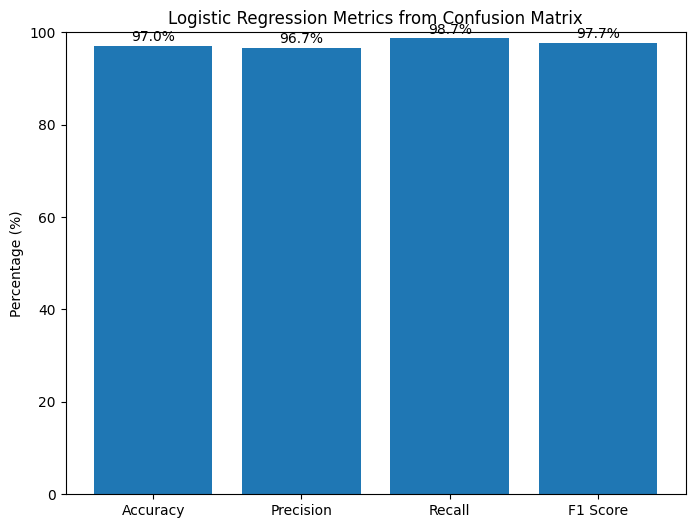

In [ ]:
import matplotlib.pyplot as plt

# After you compute tp, tn, fp, fn:
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

metrics = {
    "Accuracy": accuracy * 100,
    "Precision": precision * 100,
    "Recall": recall * 100,
    "F1 Score": f1 * 100
}

labels = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(8, 6))
plt.bar(labels, values)
plt.ylim(0, 100)
plt.ylabel("Percentage (%)")
plt.title("Logistic Regression Metrics from Confusion Matrix")
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.show()


<Figure size 600x600 with 0 Axes>

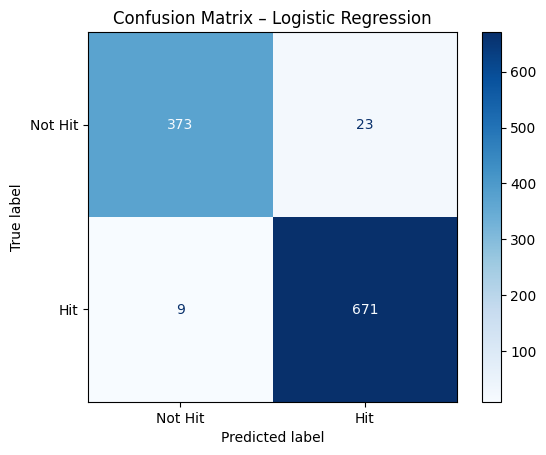

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert the 'hit' (true labels) and 'prediction' columns from the Spark DataFrame to pandas DataFrames
true_labels = predictions.select("hit").toPandas()
predicted_labels = predictions.select("prediction").toPandas()

# Compute the confusion matrix
cm_matrix = confusion_matrix(true_labels, predicted_labels)

# Prepare the display object with appropriate labels for the classes
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=["Not Hit", "Hit"])

# Create a plot for the confusion matrix
plt.figure(figsize=(6, 6))
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Train Random Forest using same features
random_forest_declaration = RandomForestClassifier(labelCol="hit", featuresCol="features", numTrees=100)
random_forest_model = random_forest_declaration.fit(train_data)

# Predict using Random Forest
random_forest_predictions = random_forest_model .transform(test_data)

# Show just the actual hit and predicted values
random_forest_predictions.select("hit", "prediction").show(10, truncate=False)


+---+----------+
|hit|prediction|
+---+----------+
|1  |1.0       |
|1  |1.0       |
|1  |1.0       |
|1  |1.0       |
|1  |1.0       |
|1  |1.0       |
|1  |1.0       |
|1  |1.0       |
|0  |0.0       |
|0  |1.0       |
+---+----------+
only showing top 10 rows



In [ ]:
# Create an evaluator for the area under the ROC curve using our label and raw prediction columns
spark_auc_evaluator = BinaryClassificationEvaluator(
    labelCol="hit",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# Calculate the AUC on the test data and print it
spark_auc = spark_auc_evaluator.evaluate(random_forest_predictions)
print("Spark Evaluator for Random Forest: {:.2f}".format(spark_auc))



Spark Evaluator for Random Forest): 0.93


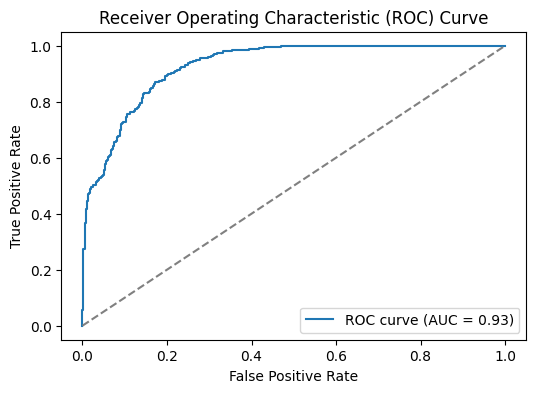

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Convert the Spark DataFrame to a pandas DataFrame
predictions_pd = random_forest_predictions.select("probability", "hit").toPandas()

# Let's extract that into a new column.
predictions_pd['positive_probability'] = predictions_pd['probability'].apply(lambda p: float(p[1]))

# This returns arrays for the false positive rate (fpr), true positive rate (tpr), and decision thresholds.
fpr, tpr, thresholds = roc_curve(predictions_pd['hit'], predictions_pd['positive_probability'])

# Compute the Area Under the Curve (AUC) which gives a single summary metric of the ROC performance.
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")

# Plot the diagonal line representing random guessing for comparison
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Label the plot axes and add a title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")

# Show the legend at the lower right and display the plot
plt.legend(loc="lower right")
plt.show()




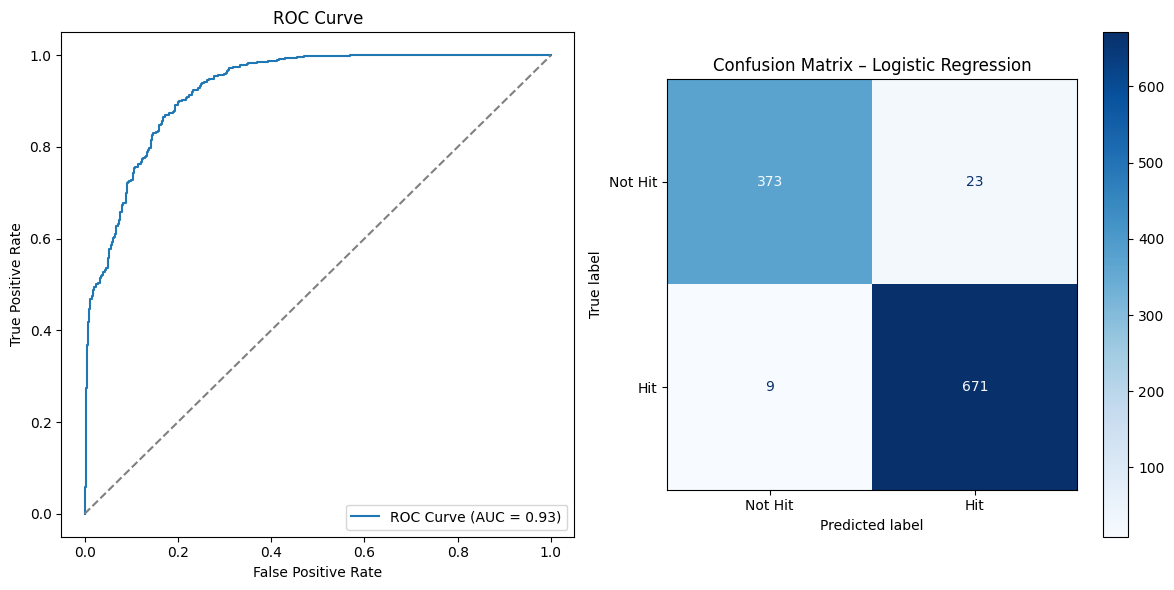

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
# Convert the necessary columns from Spark to pandas for further evaluation
true_labels = predictions.select("hit").toPandas()
predicted_labels = predictions.select("prediction").toPandas()

# Set up a figure with two side-by-side plots
fig, (roc_ax, cm_ax) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve in the left subplot
roc_ax.plot(fpr, tpr,
            label=f"ROC Curve (AUC = {roc_auc:.2f})")
roc_ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
roc_ax.set_xlabel("False Positive Rate")
roc_ax.set_ylabel("True Positive Rate")
roc_ax.set_title("ROC Curve")
roc_ax.legend(loc="lower right")

# Compute and plot the Confusion Matrix in the right subplot
cm = confusion_matrix(true_labels, predicted_labels)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hit", "Hit"])
cm_disp.plot(ax=cm_ax, cmap=plt.cm.Blues, values_format='d')
cm_ax.set_title("Confusion Matrix – Logistic Regression")

# Adjust the layout to prevent overlap and show the plots
plt.tight_layout()
plt.show()

---
# **Model Parameter Tuning**
---


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

logistics_model = LogisticRegression(labelCol="hit", featuresCol="features")

# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="hit", predictionCol="prediction", metricName="f1")

# Param grid for Logistic Regression
logistics_regression_param_grid = ParamGridBuilder() \
    .addGrid(logistics_model.regParam, [0.0, 1e-6, 1e-5, 1e-4, 1e-3]) \
    .addGrid(logistics_model.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
    .addGrid(logistics_model.maxIter, [20, 50]) \
    .addGrid(logistics_model.tol, [1e-6, 1e-4]) \
    .build()

# Tuning
logistics_regression_tuner = TrainValidationSplit(
    estimator=logistics_model,
    estimatorParamMaps=logistics_regression_param_grid,
    evaluator=evaluator,
    trainRatio=0.8
)

# Fit with tuning
logistics_regression_best_model = logistics_regression_tuner.fit(train_data)


In [ ]:
best_logistics = logistics_regression_best_model.bestModel

print("Best Logistic Regression Parameters:")
print(f"regParam: {best_logistics .getRegParam()}")
print(f"elasticNetParam: {best_logistics .getElasticNetParam()}")
print(f"maxIter: {best_logistics .getMaxIter()}")


Best Logistic Regression Parameters:
regParam: 0.0
elasticNetParam: 0.0
maxIter: 50


In [ ]:
# Make predictions on the test data using the best model
logistics_regression_best_predictions = logistics_regression_best_model.transform(test_data)

# F1 Score
f1 = evaluator.evaluate(logistics_regression_best_predictions)


# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="hit", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(logistics_regression_best_predictions)


# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="hit", predictionCol="prediction", metricName="precisionByLabel")
precision = precision_evaluator.evaluate(logistics_regression_best_predictions)


# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="hit", predictionCol="prediction", metricName="recallByLabel")
recall = recall_evaluator.evaluate(logistics_regression_best_predictions)


print(f"Logistics Regression Model Performance after tunning:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


Logistics Regression Model Performance after tunning:
Accuracy: 99.35%
Precision: 99.74%
Recall: 98.48%
F1 Score: 99.35%


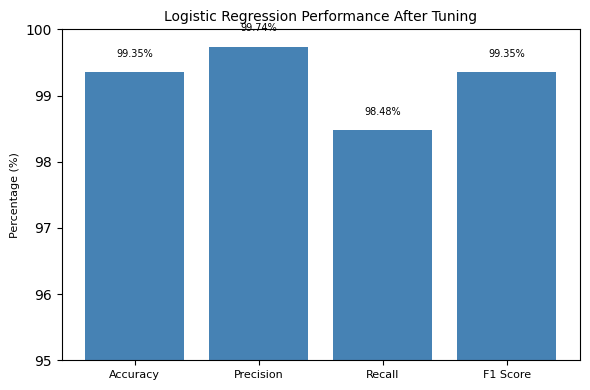

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Given metrics after tuning
metrics = {
    "Accuracy": 99.35,
    "Precision": 99.74,
    "Recall": 98.48,
    "F1 Score": 99.35
}

labels = list(metrics.keys())
values = list(metrics.values())
x = np.arange(len(labels))

plt.figure(figsize=(6, 4))
bars = plt.bar(x, values, color='steelblue')

plt.ylim(95, 100)  # Focus on the relevant range
plt.xticks(x, labels, fontsize=8)
plt.ylabel("Percentage (%)", fontsize=8)
plt.title("Logistic Regression Performance After Tuning", fontsize=10)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{height:.2f}%",
             ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

random_forest_model = RandomForestClassifier(labelCol="hit", featuresCol="features")

# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="hit", predictionCol="prediction", metricName="f1")

# Param grid for Random Forest
random_forest_param_grid = ParamGridBuilder() \
    .addGrid(random_forest_model.numTrees, [100]) \
    .addGrid(random_forest_model.maxDepth, [ 15]) \
    .addGrid(random_forest_model.minInstancesPerNode, [1, 2]) \
    .addGrid(random_forest_model.featureSubsetStrategy, ['auto', 'sqrt','log2']) \
    .build()

# Tuning
random_forest_tuner = TrainValidationSplit(
    estimator=random_forest_model,
    estimatorParamMaps=random_forest_param_grid,
    evaluator=evaluator,
    trainRatio=0.8
)

# Fit with tuning
random_forest_best_model = random_forest_tuner.fit(train_data)


In [ ]:
best_random_forest = random_forest_best_model.bestModel

print(" Best Random Forest Parameters:")
print(f"numTrees: {best_random_forest.getNumTrees}")
print(f"maxDepth: {best_random_forest.getOrDefault('maxDepth')}")
print(f"impurity: {best_random_forest.getOrDefault('impurity')}")


 Best Random Forest Parameters:
numTrees: 100
maxDepth: 15
impurity: gini


Area Under ROC (AUC) after tuning: 0.99


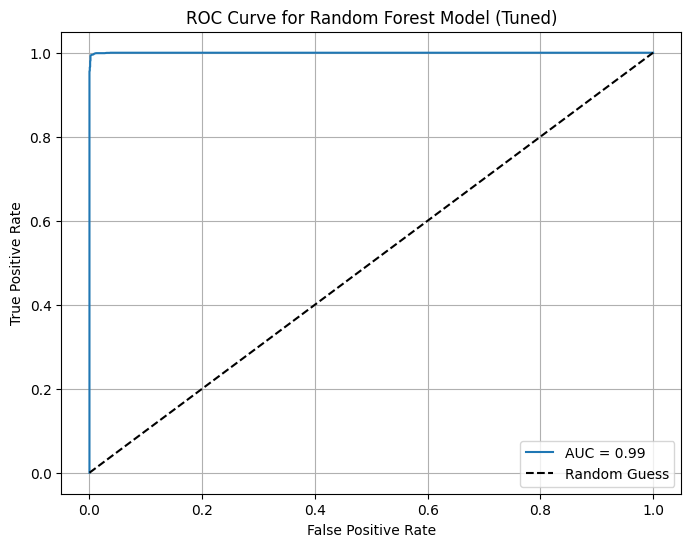

In [ ]:
# Get the best model from TrainValidationSplit
best_random_forest_model = random_forest_best_model.bestModel

# Make predictions on test data
random_forest_final_predictions = best_random_forest_model.transform(test_data)

# Evaluate with BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="hit", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(random_forest_final_predictions)
print("Area Under ROC (AUC) after tuning: {:.2f}".format(auc))

# Extract ROC data
rf_training_summary = best_random_forest_model.summary
roc_df = rf_training_summary.roc.toPandas()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(roc_df['FPR'], roc_df['TPR'], label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Model (Tuned)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

---
# **Model Evaluation and Accuracy Calculation**
---

In [ ]:
#Logistics Evaluator
confusion_matrix = predictions.groupBy("hit", "prediction").count()
confusion_matrix.show()

+---+----------+-----+
|hit|prediction|count|
+---+----------+-----+
|  1|       0.0|    9|
|  0|       0.0|  373|
|  1|       1.0|  671|
|  0|       1.0|   23|
+---+----------+-----+



In [ ]:
cm_pandas = confusion_matrix.toPandas()
cm_pandas.pivot(index ='hit',  columns = 'prediction', values = 'count')


prediction,0.0,1.0
hit,,
0,373,23
1,9,671


In [ ]:
tp = predictions[(predictions.hit == 1) & (predictions.prediction == 1)].count()
fp = predictions[(predictions.hit == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.hit == 1) & (predictions.prediction == 0)].count()
tn = predictions[(predictions.hit == 0) & (predictions.prediction == 0)].count()


In [ ]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)


print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")
print(f"Logistic Regression F1 Score: {f1 * 100:.2f}%")
print(f"Logistic Regression Precision: {precision * 100:.2f}%")
print(f"Logistic Regression Recall: {recall * 100:.2f}%")

Logistic Regression Accuracy: 97.03%
Logistic Regression F1 Score: 97.67%
Logistic Regression Precision: 96.69%
Logistic Regression Recall: 98.68%


<Figure size 600x600 with 0 Axes>

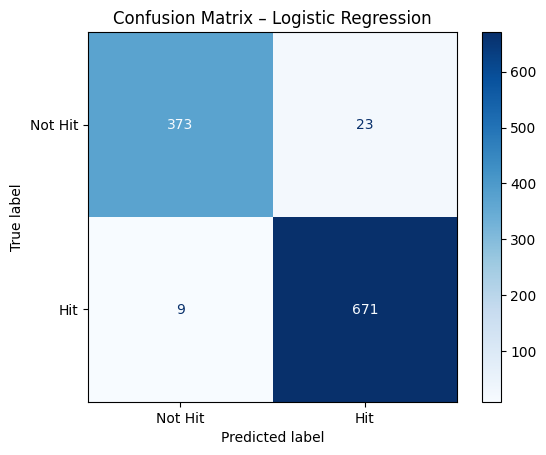

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert the 'hit' (true labels) and 'prediction' columns from the Spark DataFrame to pandas DataFrames
true_labels = predictions.select("hit").toPandas()
predicted_labels = predictions.select("prediction").toPandas()

# Compute the confusion matrix
cm_matrix = confusion_matrix(true_labels, predicted_labels)

# Prepare the display object with appropriate labels for the classes
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=["Not Hit", "Hit"])

# Create a plot for the confusion matrix
plt.figure(figsize=(6, 6))
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

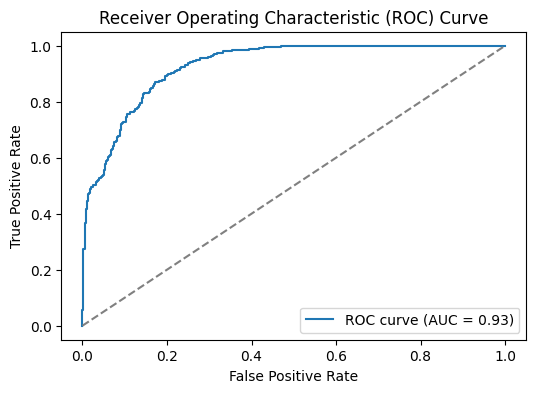

In [ ]:
#Libraries_import
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Convertion_Spark DataFrame_to_pandas DataFrame
predictions_pd = random_forest_predictions.select("probability", "hit").toPandas()

# Let's extract that into a new column.
predictions_pd['positive_probability'] = predictions_pd['probability'].apply(lambda p: float(p[1]))

# This returns arrays for the false positive rate (fpr), true positive rate (tpr), and decision thresholds.
fpr, tpr, thresholds = roc_curve(predictions_pd['hit'], predictions_pd['positive_probability'])

# Compute the Area Under the Curve (AUC) which gives a single summary metric of the ROC performance.
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")

# Plot the diagonal line representing random guessing for comparison
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Label the plot axes and add a title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")

# Show the legend at the lower right and display the plot
plt.legend(loc="lower right")
plt.show()

# **Results Visualization or Printing**

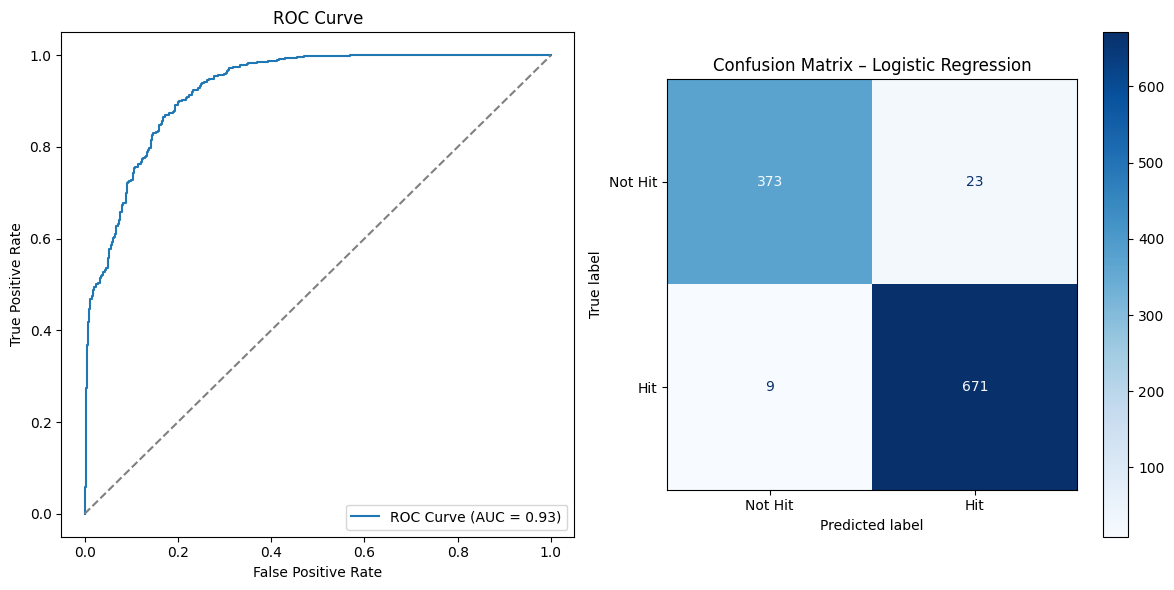

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Convert the necessary columns from Spark to pandas for further evaluation
true_labels = predictions.select("hit").toPandas()         #original_labels
predicted_labels = predictions.select("prediction").toPandas()  #machine_predictions

# Set up a figure with two side-by-side plots
fig, (roc_ax, cm_ax) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve in the left subplot
roc_ax.plot(fpr, tpr,
            label=f"ROC Curve (AUC = {roc_auc:.2f})")
roc_ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
roc_ax.set_xlabel("False Positive Rate")
roc_ax.set_ylabel("True Positive Rate")
roc_ax.set_title("ROC Curve")
roc_ax.legend(loc="lower right")

# Compute and plot the Confusion Matrix in the right subplot
cm = confusion_matrix(true_labels, predicted_labels)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hit", "Hit"])
cm_disp.plot(ax=cm_ax, cmap=plt.cm.Blues, values_format='d')
cm_ax.set_title("Confusion Matrix – Logistic Regression")

# Adjust the layout to prevent overlap and show the plots
plt.tight_layout()
plt.show()

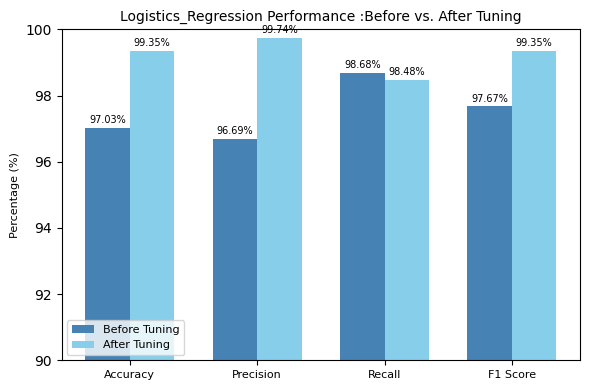

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics_before_tuning
before_tuning = [97.03, 96.69, 98.68, 97.67]

#  Metrics_after_tuning
after_tuning  = [99.35, 99.74, 98.48, 99.35]

labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
x = np.arange(len(labels))
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(6, 4))

# Two shades of blue
bars_before = ax.bar(x - width/2, before_tuning, width, label='Before Tuning', color='steelblue')
bars_after  = ax.bar(x + width/2, after_tuning,  width, label='After Tuning',  color='skyblue')

ax.set_ylabel('Percentage (%)', fontsize=8)
ax.set_title('Logistics_Regression Performance :Before vs. After Tuning', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=8)
ax.set_ylim(90, 100)

# positioning_legend_in_the_graph
ax.legend(loc='lower left', fontsize=8)

# bars
for bar in bars_before + bars_after:
    h = bar.get_height()
    ax.annotate(f'{h:.2f}%',
                xy=(bar.get_x()+bar.get_width()/2, h),
                xytext=(0,2), textcoords='offset points',
                ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()


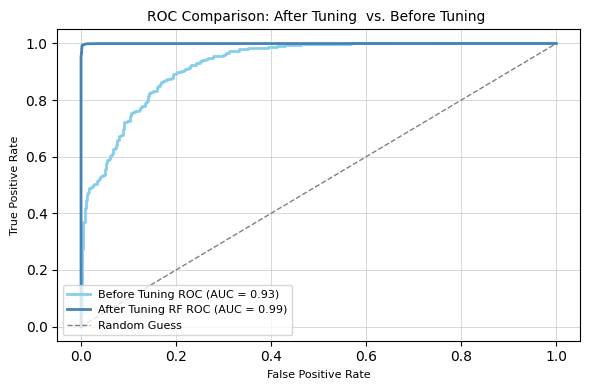

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc as sk_auc



# Before_Tuning and ROC points
preds_pd = random_forest_predictions.select("probability", "hit").toPandas()
preds_pd['pos_prob'] = preds_pd['probability'].apply(lambda p: float(p[1]))
fpr, tpr, _ = roc_curve(preds_pd['hit'], preds_pd['pos_prob'])
sk_auc_val = sk_auc(fpr, tpr)

# After_Tuning and ROC points
spark_auc = evaluator.evaluate(random_forest_final_predictions)
roc_df = best_random_forest_model.summary.roc.toPandas()

# Plotting the both graph curves
plt.figure(figsize=(6, 4))


# Before Tuning curves
plt.plot(
    fpr, tpr,
    color='skyblue', lw=2,
    label=f"Before Tuning ROC (AUC = {sk_auc_val:.2f})"

)

# After Tuning  curve
plt.plot(
    roc_df['FPR'], roc_df['TPR'],
    color='steelblue', lw=2,
    label=f"After Tuning RF ROC (AUC = {spark_auc:.2f})"
)

# Random guess line
plt.plot([0, 1], [0, 1],
         linestyle='--', color='gray', lw=1,
         label='Random Guess')

plt.xlabel("False Positive Rate", fontsize=8)
plt.ylabel("True Positive Rate", fontsize=8)
plt.title("ROC Comparison: After Tuning  vs. Before Tuning ", fontsize=10)
plt.legend(loc='lower left', fontsize=8)
plt.grid(True, linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


# **Ethical Consideration of Using Movie Data From Kaggle**


**Ethical Thoughts While Working with the Kaggle Movie Dataset
Starting Off – Why We Even Thought About Ethics**

So when we began using the movie dataset from Kaggle to figure out which films made a profit, it wasn’t just about numbers. We had to ask ourselves—are we using this data responsibly? It might seem like a harmless prediction model, but the way we handle the info (and what we do with it) can have real consequences. That’s why we made ethics part of the process from the start not just an afterthought.

 **Privacy – Did We Need to Worry?**

Honestly, we didn’t find anything like names, emails, or personal financial records in the dataset. But if there had been, our first move would've been to remove or blur those details. It’s basic respect—no one wants their info in a public dataset without knowing. Even though nothing like that came up, it’s still something we kept in mind.

**Bias – What We Noticed and Tried to Fix**

This one hit us early. A lot of the data leaned heavily in one direction, and there wasn’t as much variety overall. That could mess with our predictions—like assuming smaller-budget projects always flop, which isn’t fair. We spent some time checking category spread and trying to balance the samples, so it wouldn’t just learn from one side of the story.

**Being Clear About What We Did**

We made it a point to keep notes on how we cleaned and processed the data, especially with things like missing revenue figures. Some of the older entries didn’t have full data, and instead of ignoring that, we were upfront about it. By doing this, we made sure the necessary steps were taken for anyone else who might use the model—they’ll see those gaps clearly. It’s better that way.


**Credit and Copyright**

The dataset came from Kaggle, so of course we mentioned that and stayed within their rules. We weren’t trying to make money off this or publish anything commercial. And we avoided using movie scripts or other stuff that might be copyrighted—just kept things simple and legal.

**Real-World Impact**

Here’s the part that really made us think: what if someone actually used this model to help decide which movies get made? If it favors certain genres or budgets, it might overlook creative projects that don’t fit the mold. That didn’t sit right with us. So we added a warning that this tool is just a helper—not something that should replace real judgment. People should know what the model can and can’t do.

**Laws and Rules**

We followed all the guidelines from Kaggle, and we made sure nothing violated GDPR or any other data rules (especially since we’re based in the UK/EU). If anything looked unclear, we leaned on the side of caution and left it out.

**Final Takeaway**

In the end, we didn’t just want to build a decent prediction model—we wanted to feel good about how we got there. Ethics isn’t a checklist you tick once; it’s something you keep thinking about through every step. We’ve tried to do just that.